In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import skimage
from skimage import io

##Import any other packages you may need here
from itertools import chain

EDA is open-ended, and it is up to you to decide how to look at different ways to slice and dice your data. A good starting point is to look at the requirements for the FDA documentation in the final part of this project to guide (some) of the analyses you do. 

This EDA should also help to inform you of how pneumonia looks in the wild. E.g. what other types of diseases it's commonly found with, how often it is found, what ages it affects, etc. 

Note that this NIH dataset was not specifically acquired for pneumonia. So, while this is a representation of 'pneumonia in the wild,' the prevalence of pneumonia may be different if you were to take only chest x-rays that were acquired in an ER setting with suspicion of pneumonia. 

Perform the following EDA:
* The patient demographic data such as gender, age, patient position,etc. (as it is available)
* The x-ray views taken (i.e. view position)
* The number of cases including: 
    * number of pneumonia cases,
    * number of non-pneumonia cases
* The distribution of other diseases that are comorbid with pneumonia
* Number of disease per patient 
* Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.

Note: use full NIH data to perform the first a few EDA items and use `sample_labels.csv` for the pixel-level assassements. 

Also, **describe your findings and how will you set up the model training based on the findings.**

In [2]:
## Below is some helper code to read data for you.
## Load NIH data
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_xray_df.sample(3)

## Load 'sample_labels.csv' data for pixel level assessments
sample_df = pd.read_csv('sample_labels.csv')
sample_df.sample(4)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
800,00004168_004.png,No Finding,4,4168,011Y,F,PA,2048,2500,0.168,0.168
3137,00015448_002.png,Atelectasis,2,15448,061Y,F,AP,2500,2048,0.168,0.168
1504,00007830_003.png,Mass|Pneumothorax,3,7830,010Y,M,AP,2048,2500,0.168,0.168
5527,00030134_000.png,No Finding,0,30134,054Y,F,AP,3056,2544,0.139,0.139


In [3]:
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}

In [4]:
# Split Finding Labels into 1-hot encoding

all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
all_xray_df.sample(3)

# Split for sample dataset
all_labels = np.unique(list(chain(*sample_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        sample_df[c_label] = sample_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
sample_df.sample(3)


All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']
All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
1152,00006040_008.png,No Finding,8,6040,021Y,F,PA,2686,2721,0.143,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3786,00018607_001.png,Mass,1,18607,064Y,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3544,00017526_000.png,Infiltration,0,17526,065Y,M,PA,2992,2989,0.143,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
## EDA
# Todo 

# EDA

## Patient Demographics

### Age

In [6]:
all_xray_df['Patient Age'].describe()

count    112120.000000
mean         46.901463
std          16.839923
min           1.000000
25%          35.000000
50%          49.000000
75%          59.000000
max         414.000000
Name: Patient Age, dtype: float64

--> There are some entries that could be considered a mistake. 16 entries mention that their age is beyond 110. Someone apparently has 414 years (I need to meet that guy or gal). So we rule out those from the dataset and just focus on the patient's whose age is below 100 years old.

(array([ 1803.,  5021., 12798., 14580., 18664., 26481., 20790.,  9793.,
         1917.,   257.]),
 array([ 1. , 10.4, 19.8, 29.2, 38.6, 48. , 57.4, 66.8, 76.2, 85.6, 95. ]),
 <a list of 10 Patch objects>)

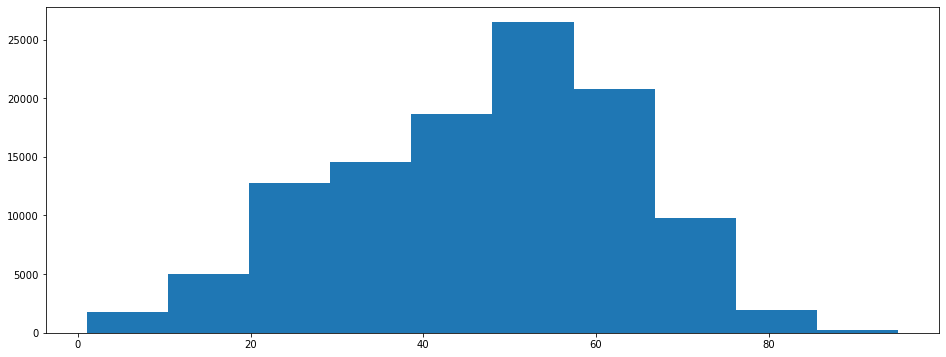

In [7]:
#Age
age_df = all_xray_df[all_xray_df['Patient Age']<100]

#Plot
plt.figure(figsize=(16,6))
x = age_df['Patient Age']
plt.hist(x, range=(x.min(), x.max()), bins=10)

In [8]:
bins= [0,10,20,30,40,50,60,70,80,90,100]
labels = ['0-10','11-20','21-30','31-40','41-50','51-60','61-70','71-80','81-90','91-100',]
age_df['AgeGroup'] = pd.cut(age_df['Patient Age'], bins=bins, labels=labels, right=False)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [9]:
age_df['AgeGroup'].value_counts()/len(age_df)

51-60     0.244469
41-50     0.193847
61-70     0.171912
31-40     0.145517
21-30     0.114162
71-80     0.059240
11-20     0.048357
0-10      0.012515
81-90     0.009402
91-100    0.000580
Name: AgeGroup, dtype: float64

Our new dataset with 100 and under people is age_df. We notice that the majo

### Gender

Value Counts:
M    63328
F    48776
Name: Patient Gender, dtype: int64
M    0.564904
F    0.435096
Name: Patient Gender, dtype: float64


(array([63328.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 48776.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

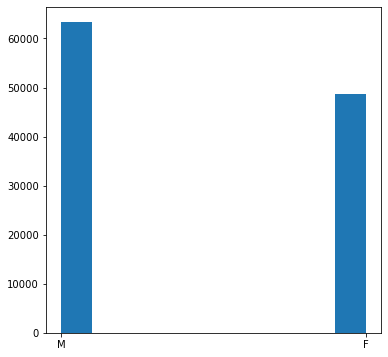

In [10]:
#Gender
print("Value Counts:")
print(age_df['Patient Gender'].value_counts())
print(age_df['Patient Gender'].value_counts()/len(age_df))

#Plot
plt.figure(figsize=(6,6))
x = age_df['Patient Gender']
plt.hist(x)

Value Counts:
PA    67299
AP    44805
Name: View Position, dtype: int64
PA    0.600326
AP    0.399674
Name: View Position, dtype: float64


(array([67299.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 44805.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

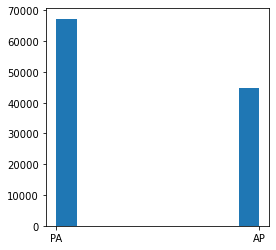

In [11]:
#View Position
print("Value Counts:")
print(age_df['View Position'].value_counts())
print(age_df['View Position'].value_counts()/len(age_df))

#Plot
plt.figure(figsize=(4,4))
x = age_df['View Position']
plt.hist(x)

So, from our analysis:

1. We had to rule out 16 wrong age.
2. There is a greater presence of Male vs Female in this dataset. So there might be a bias towards "Male". Male population is 53% and Female is 43%.
3. There might also be a strong bias towards PA type of images in terms of View Position. Its a 3:2 ratio between PA:AP

## Disease Analysis

### Pneumonia

In [12]:
age_df["Pneumonia"].value_counts()

0.0    110674
1.0      1430
Name: Pneumonia, dtype: int64

In [13]:
age_df["Pneumonia"].value_counts()/len(age_df)

0.0    0.987244
1.0    0.012756
Name: Pneumonia, dtype: float64

### Disease Distribution and Comorbidity with Pneumonia

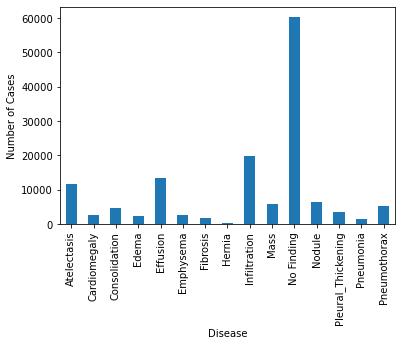

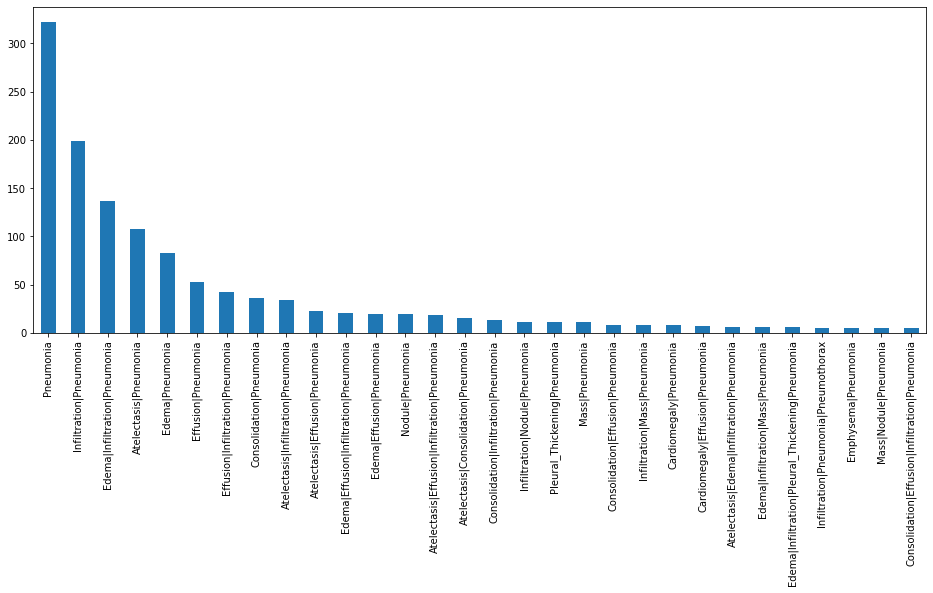

In [14]:
#Measure frequency
age_df[all_labels].sum()/len(age_df)

#plot 
ax = (age_df[all_labels].sum()).plot(kind='bar')
ax.set(ylabel='Number of Cases')
ax.set(xlabel='Disease')

#plot distribution picking up top 30%
plt.figure(figsize=(16,6))
age_df[age_df.Pneumonia==1]["Finding Labels"].value_counts()[0:30].plot(kind='bar')

Analysis: 

So, there are 1431 positive Pnuemonia cases in the dataset and 110689 non-pneumonia cases, which constitutes a 1.2% of cases. Also, we notice that Pneumonia is much more common either alone or in company of Infiltration, Edema, and Atelectasis

### Number of diseases per patient

In [15]:
number_diseases = age_df["Pneumonia"]+age_df["Edema"]+age_df['Atelectasis']+age_df['Cardiomegaly']+age_df['Consolidation']+age_df['Effusion']+age_df['Emphysema']+age_df['Fibrosis']+age_df['Hernia']+age_df['Infiltration']+age_df['Mass']+age_df['Nodule']+age_df['Pleural_Thickening']+age_df['Pneumothorax']
number_diseases.describe()

count    112104.000000
mean          0.724006
std           0.963213
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max           9.000000
dtype: float64

(array([6.0353e+04, 3.0959e+04, 1.4302e+04, 4.8560e+03, 1.2470e+03,
        3.0100e+02, 6.7000e+01, 1.6000e+01, 1.0000e+00, 2.0000e+00]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

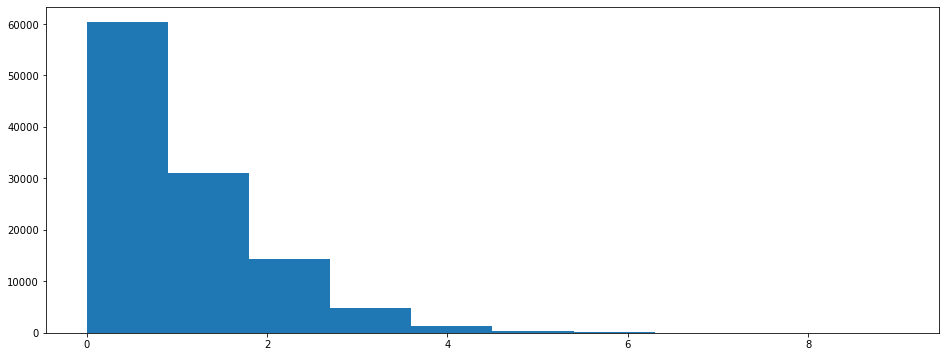

In [16]:
#Plot
plt.figure(figsize=(16,6))
x = number_diseases
plt.hist(x)

It seems that the majority of the people have none or just 1 disease.

Now, lets get to the images

## X-ray Images

In [17]:
sample_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
1963,00010294_006.png,Consolidation,6,10294,050Y,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
944,00004911_028.png,Nodule,28,4911,049Y,F,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4696,00023853_000.png,Fibrosis,0,23853,055Y,M,PA,2986,2917,0.143,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
#my_glob = glob('../input/images*/images/*.png')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', age_df.shape[0])
age_df['path'] = age_df['Image Index'].map(all_image_paths.get)
age_df.sample(3)
#plt.imshow(io.imread('data/images/00017610_000.png'))
#plt.imshow(io.imread('input/images/'+str(age_df['Image Index'][0]))) sample_df["Image Index"]))

Scans found: 112120 , Total Headers 112104


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,AgeGroup,path
101080,00026833_005.png,Effusion|Infiltration,5,26833,47,F,AP,3056,2544,0.139,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,41-50,/data/images_011/images/00026833_005.png
32827,00008592_000.png,Atelectasis|Infiltration,0,8592,61,M,PA,2500,2048,0.168,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,61-70,/data/images_004/images/00008592_000.png
96962,00025561_008.png,No Finding,8,25561,50,M,AP,3056,2544,0.139,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,51-60,/data/images_011/images/00025561_008.png


In [19]:
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', sample_df.shape[0])
sample_df['path'] = sample_df['Image Index'].map(all_image_paths.get)
sample_df.sample(3)

Scans found: 112120 , Total Headers 5606


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,path
5006,00026451_027.png,Effusion|Infiltration|Pneumothorax,27,26451,051Y,M,AP,3056,2544,0.139,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,/data/images_011/images/00026451_027.png
2034,00010550_000.png,No Finding,0,10550,056Y,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,/data/images_005/images/00010550_000.png
1236,00006517_003.png,Consolidation,3,6517,045Y,F,AP,2500,2048,0.171,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,/data/images_003/images/00006517_003.png


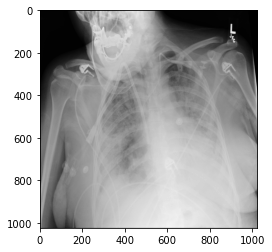

In [20]:
plt.imshow(io.imread('/data/images_006/images/00011702_029.png'), cmap="gray")

### Intensity Values

In [21]:
def plot_histogram(img, title):
    plt.subplot()
    plt.hist(img.ravel(),bins=256)
    title = str(title) + ' Positive Intensity Values'
    plt.title(title)
    plt.show()

In [22]:
def plot_2_hist(img_list, title):
    img_list= img_list
    
    fig, axs = plt.subplots(1, 4, sharey=True)

    # We can set the number of bins with the `bins` kwarg
    axs[0].hist(img_list[0].ravel(), bins=256)
    axs[1].hist(img_list[1].ravel(), bins=256)
    axs[2].hist(img_list[2].ravel(), bins=256)
    axs[3].hist(img_list[3].ravel(), bins=256)
    
    title = str(title) + ' Positive Intensity Values'
    plt.title(title)
    plt.show
    

In [23]:
def process_img(df, disease):
    
    img_list = []
    j = 0
    for i in df.values:
        
        #pre-process image
        i_path = df.path.iloc[j]
        i_img = io.imread(i_path)
        
        #normalize i_img
        i_mean = i_img.mean()
        i_std = i_img.std()
        normalized_img = (i_img-i_mean)/i_std
        
        img_list.append(normalized_img)
        print(i_path)
        
        #plot-INDIVIDUAL
        #plot_histogram(i_img, disease)
        j+=1
        
    #plot 2 imags
    
    plot_2_hist(img_list, disease)

Disease: Atelectasis
/data/images_010/images/00021860_006.png
/data/images_007/images/00015343_003.png
/data/images_003/images/00005064_008.png
/data/images_002/images/00002072_006.png
Disease: Cardiomegaly
/data/images_001/images/00000448_000.png
/data/images_001/images/00001232_003.png
/data/images_002/images/00001373_002.png
/data/images_008/images/00017055_006.png
Disease: Consolidation
/data/images_005/images/00010357_003.png
/data/images_012/images/00029088_009.png
/data/images_007/images/00014203_017.png
/data/images_005/images/00010698_045.png
Disease: Edema
/data/images_004/images/00007332_002.png
/data/images_008/images/00016971_039.png
/data/images_001/images/00000459_041.png
/data/images_009/images/00018829_005.png
Disease: Effusion
/data/images_007/images/00015556_001.png
/data/images_009/images/00020230_001.png
/data/images_005/images/00009579_000.png
/data/images_004/images/00008777_004.png
Disease: Emphysema
/data/images_010/images/00023168_005.png
/data/images_011/imag

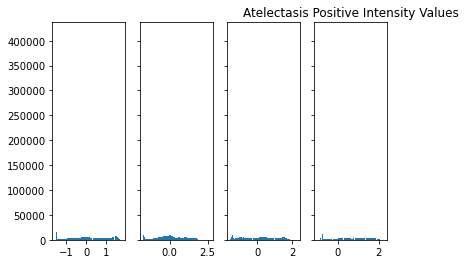

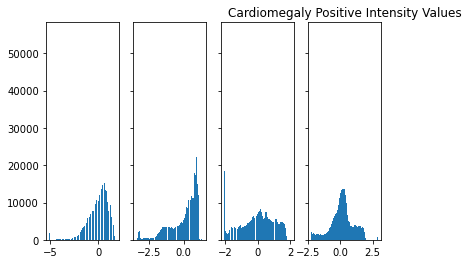

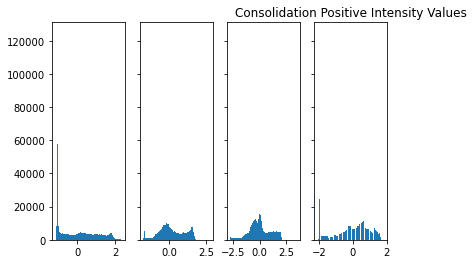

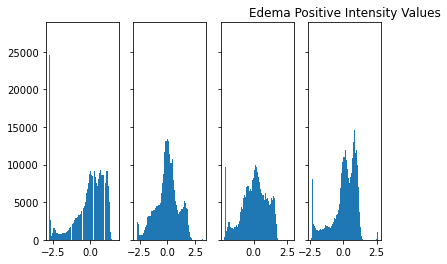

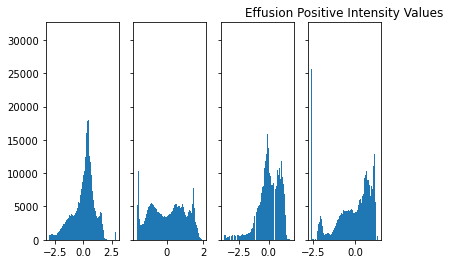

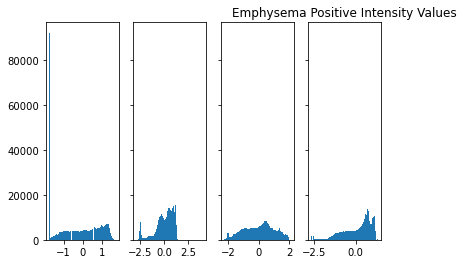

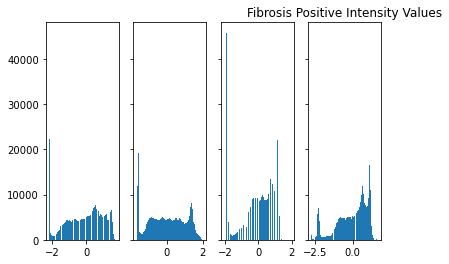

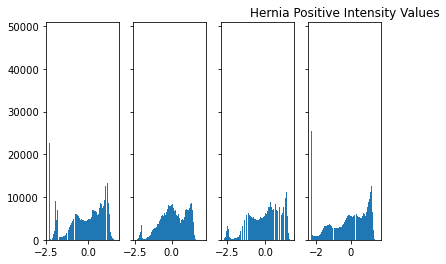

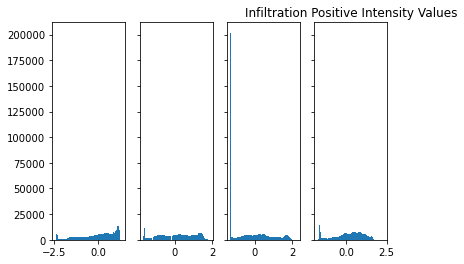

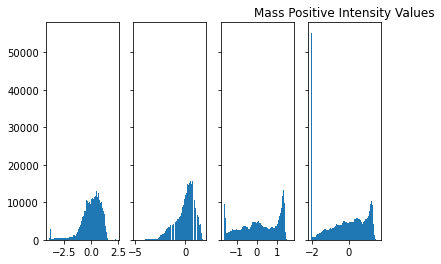

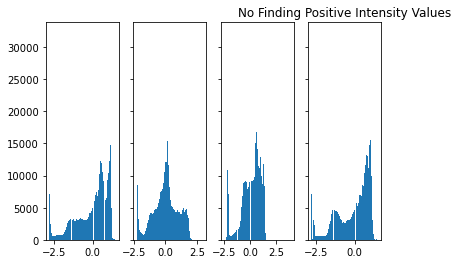

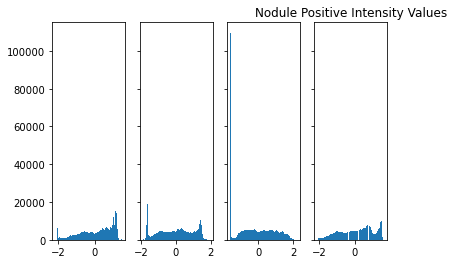

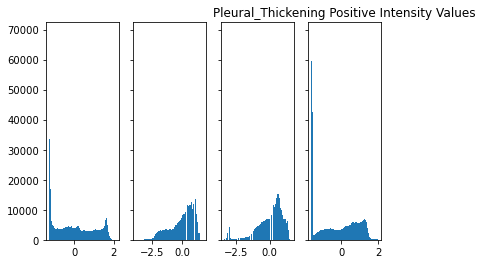

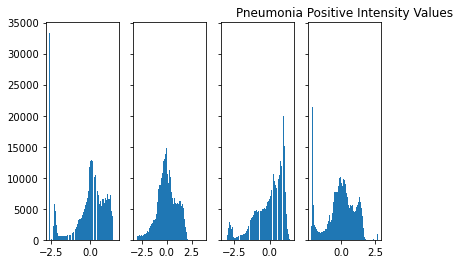

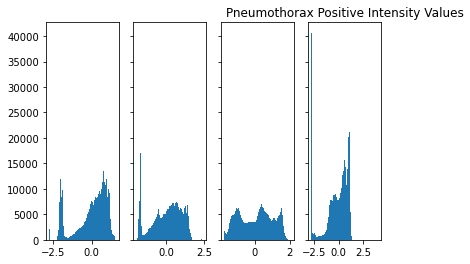

In [24]:
for i in all_labels:
    print('Disease: %s' %i)
    sample_df = age_df[age_df[i]==1]
    sample_df = sample_df.sample(4)
    process_img(sample_df, i )
    

### Intensity Value Appreciation

We can notice how positive pneumonia cases show a higher count in brighter pixels (closer to 250), instead the negative case has a much higher count of pixels with low intensity values such as 50.

Based on our quick histogram analysis, we identify a potential limitation of our algorithm misdiagnosing as Pneumonia positive in cases where there might be a presence of Cardiomegaly, Edema, and Mass. These diseases seem to show 'relatively' similar intensity values, which basically means it looks pretty similar to Pneumonia.